## Read in data
2019.07.26

In [2]:
#_*_coding:utf-8_*_
# author: Fukun Shi
# 2019-07-12
'''
计算由16451B或其他平行板电极测试地材料的介电谱和导电率的平均值. 
'''
import pandas as pd
import numpy as np
import os
import scipy.constants as c
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('nbagg')

%matplotlib inline

def listsheet(fp):
    '''列出读取excel文件的sheet名,用在main函数中'''
    IS = pd.ExcelFile(fp)
    nsheets = IS.sheet_names[2:]  # 提取每个数据对应的sheet名，用于后面的命名
    nsheet = np.size(nsheets)     # 计算含有多少个sheets
    print(nsheets)
    return nsheets, nsheet

def rawdata(filepath,i, m=402, fl=4e1, fh=5e6):
    '''读取每个sheet的数据,用在main函数中'''
    EIS = pd.read_excel(filepath, sheet_name=[i+2],header=[9], skiprows=0, skipfooter=801-m+1, usecols=[2,3,5]) # read_excel 各参数解释：首先是读取的文件路径和文件名，然后sheet_name指定要读取的sheets，skipfooter是从尾部开始忽略的行数，usecols指定要读取的列
    EIS = EIS[i+2].values   # 将数据转为ndarray,方便转为pandas的dataframe形式
    # pd.read_excel直接读取，如果sheet_name不是默认值，结果都不是dataframe格式，需要转换为dataframe
    EIS = pd.DataFrame(EIS, columns=['Frequency','Re_Z', 'Im_Z'])
    EIS = EIS[(EIS.Frequency>=fl)&(EIS.Frequency<=fh)]
    EIS['w'] = 2*EIS.Frequency*np.pi
    EIS['Capacitance'] = -1/(EIS['w']*EIS['Im_Z'])
    return EIS

def toED(Z,thickness):
    '''将读取的阻抗谱数据转换成介电谱,用在main函数中'''
    ed = pd.DataFrame()
    ed['Permittivity'] = thickness*Z['Capacitance']/(A*c.epsilon_0)
    ed['Conductivity'] = thickness/(Z['Re_Z']*A)
    ed['Dielectric_loss'] = ed['Conductivity']/(Z['w']*c.epsilon_0)
    return ed

def main(filepath,thickness):
    '''output separatively relative permittivity and conductivity'''
    #global RawZ
    nsheets, nsheet=listsheet(filepath)
    Ep = pd.DataFrame()
    Con = pd.DataFrame()
    for i in range(nsheet):
        RawZ = rawdata(filepath,i)
        ed = toED(RawZ, thickness[i])
        A = pd.DataFrame()
        B = pd.DataFrame()
        A[nsheets[i]] = ed['Permittivity']
        B[nsheets[i]] = ed['Conductivity']
        Ep = pd.concat([Ep,A],axis=1)
        Con = pd.concat([Con,B],axis=1)
    Ep['Frequency'] = RawZ['Frequency']
    Con['Frequency'] = RawZ['Frequency']
    return Ep, Con
## 操作时调用main函数即可        
        
#____________________________________________________________________________________________
def readexcel(filepath, thickness, m=402, fl=4e1, fh=5e6):
    '''to read raw impedance data, and transfer to dielectric and conductivity.
    **filepath** is the filepath for the specific excel file, 
    **m** is the impedance points, 
    **thickness** is a list or array to indicate the thickness of each sample (unit/m)'''
    IS = pd.ExcelFile(filepath)
    nsheets = IS.sheet_names[2:]  # 提取每个数据对应的sheet名，用于后面的命名
    nsheet = np.size(nsheets)     # 计算含有多少个sheets
    Z = pd.DataFrame()
    for i in range(nsheet):
        EIS = pd.read_excel(filepath, sheet_name=[i+2],header=[9], skiprows=0, skipfooter=801-m+1, usecols=[2,3,5]) # read_excel 各参数解释：首先是读取的文件路径和文件名，然后sheet_name指定要读取的sheets，skipfooter是从尾部开始忽略的行数，usecols指定要读取的列
        EIS = EIS[i+2].values   # 将数据转为ndarray,方便转为pandas的dataframe形式
        # pd.read_excel直接读取，如果sheet_name不是默认值，结果都不是dataframe格式，需要转换为dataframe
        sheetname = nsheets[i]
        EIS = pd.DataFrame(EIS, columns=['Frequency',sheetname+'Re_Z', sheetname+'Im_Z'])
        EIS = EIS[(EIS.Frequency>=fl)&(EIS.Frequency<=fh)]
        
        w = 2*np.pi*EIS['Frequency']
        C = -1/(w*EIS[sheetname+'Im_Z'])
        c.epsilon_0                               # 具体常数信息可以用c.physical_constants['name']读取
    
        EIS[sheetname+'Permittivity'] = thickness[i]*C/(A*c.epsilon_0)  # 相对介电常数
        EIS[sheetname+'Conductivity'] = thickness[i]/(EIS[sheetname+'Re_Z']*A)              # 电导率
        EIS[sheetname+'Dielectric_loss'] = EIS[sheetname+'Conductivity']/(w*c.epsilon_0)        # 相对损耗因子
        Z = pd.concat((Z,EIS.iloc[:,1:]),axis=1)
    
    return Z

## Input parameters

In [30]:
d = 0.5e-2           # 电极直径 m
A = np.pi*(d/2)**2   # 电极面积

thickness0 = np.array([]) # unit/mm
thickness1 = np.array([2.75
,2.93
,2.695
,2.913,3.405
,2.952
,2.858
,3.166
,2.965
,2.983
,2.962
,3.095
])
t0 = thickness0.repeat(2)
t1 = thickness1.repeat(3)
thickness = np.hstack((t1))*1e-3 # unit/m


## Path of the raw data

In [28]:
fp0 = "D:\\Bioelectrics\\Hydrogels"
fp10 = 'Christian_Polley'
fp11 = 'Caroline'
fp12 = '2019-08-14'
fp1 = os.path.join(fp0,fp10,fp11,fp12)
fn0 = '4294A_DataTransfer_0310.xlsx'
fp2 = os.path.join(fp1,fn0)
fp2

'D:\\Bioelectrics\\Hydrogels\\Christian_Polley\\Caroline\\2019-08-14\\4294A_DataTransfer_0310.xlsx'

In [29]:
RawZ = listsheet(fp2)

['V4WP3-A4 0', 'V4WP3-A4 1', 'V4WP3-A4 2', 'V4WP3-B4 0', 'V4WP3-B4 1', 'V4WP3-B4 2', 'V4WP3-C4 0', 'V4WP3-C4 1', 'V4WP3-C4 2', 'V4WP3-A3 0', 'V4WP3-A3 1', 'V4WP3-A3 2', 'V4WP3-B3 0', 'V4WP3-B3 1', 'V4WP3-B3 2', 'V4WP3-C3 0', 'V4WP3-C3 1', 'V4WP3-C3 2', 'V4WP3-A2 0', 'V4WP3-A2 1', 'V4WP3-A2 2', 'V4WP3-B2 0', 'V4WP3-B2 1', 'V4WP3-B2 2', 'V4WP3-C2 0', 'V4WP3-C2 1', 'V4WP3-C2 2', 'V4WP3-A1 0', 'V4WP3-A1 1', 'V4WP3-A1 2', 'V4WP3-B1 0', 'V4WP3-B1 1', 'V4WP3-B1 2', 'V4WP3-C1 0', 'V4WP3-C1 1', 'V4WP3-C1 2']


## Output

In [31]:
Result = main(fp2, thickness)

['V4WP3-A4 0', 'V4WP3-A4 1', 'V4WP3-A4 2', 'V4WP3-B4 0', 'V4WP3-B4 1', 'V4WP3-B4 2', 'V4WP3-C4 0', 'V4WP3-C4 1', 'V4WP3-C4 2', 'V4WP3-A3 0', 'V4WP3-A3 1', 'V4WP3-A3 2', 'V4WP3-B3 0', 'V4WP3-B3 1', 'V4WP3-B3 2', 'V4WP3-C3 0', 'V4WP3-C3 1', 'V4WP3-C3 2', 'V4WP3-A2 0', 'V4WP3-A2 1', 'V4WP3-A2 2', 'V4WP3-B2 0', 'V4WP3-B2 1', 'V4WP3-B2 2', 'V4WP3-C2 0', 'V4WP3-C2 1', 'V4WP3-C2 2', 'V4WP3-A1 0', 'V4WP3-A1 1', 'V4WP3-A1 2', 'V4WP3-B1 0', 'V4WP3-B1 1', 'V4WP3-B1 2', 'V4WP3-C1 0', 'V4WP3-C1 1', 'V4WP3-C1 2']


In [33]:
Ep

,V4WP3-A4 0,V4WP3-A4 1,V4WP3-A4 2,V4WP3-B4 0,V4WP3-B4 1,V4WP3-B4 2,V4WP3-C4 0,V4WP3-C4 1,V4WP3-C4 2,V4WP3-A3 0,...,V4WP3-A1 0,V4WP3-A1 1,V4WP3-A1 2,V4WP3-B1 0,V4WP3-B1 1,V4WP3-B1 2,V4WP3-C1 0,V4WP3-C1 1,V4WP3-C1 2,Frequency
0,16.817074,-3.343300,22.809434,-8.876849,130.243893,85.187467,-22.961265,107.121547,-459.523615,7.618312,...,207.851525,292.088440,328.838245,34.926847,80.934488,145.905531,651.462178,677.706953,672.438473,4.000000e+01
1,106.926684,46.396777,9.513810,8.562240,56.165233,-199.372366,-23.764217,16.803457,4.151184,-231.585860,...,210.797460,277.026438,277.469029,47.100245,79.843418,86.866798,661.288183,672.318203,647.237358,4.125900e+01
2,29.815925,34.227042,4.665697,24.982644,31.631484,17.988890,22.142156,12.064274,19.593154,19.516892,...,167.636077,237.721106,243.602909,58.401686,77.435880,107.061852,669.035042,666.677988,671.367765,4.255800e+01
3,19.049698,19.586725,11.296893,22.719259,14.147913,30.882007,32.525305,20.960255,-6.925049,37.277672,...,174.442388,319.293419,260.720970,58.926122,80.717410,119.120292,669.977771,678.548434,678.062447,4.389800e+01
4,27.301585,16.154551,28.064708,11.626009,8.367970,135.201155,21.354468,21.391458,29.552321,41.030365,...,189.706104,246.990490,276.552194,85.635318,81.582574,92.173916,656.999536,653.348235,647.713830,4.528000e+01
5,16.964432,-2.821557,10.164652,22.517132,6.181430,17.660656,13.627766,16.253338,8.163373,20.314224,...,175.742895,255.859670,292.627281,116.693458,79.096038,96.824607,653.485866,697.897614,658.859680,4.670500e+01
6,5.799889,-10.554250,16.080812,17.915571,8.398122,16.769780,-10.800410,9.326098,12.919410,29.540264,...,224.403781,307.395474,306.050463,95.103069,85.850607,47.135041,627.218608,649.070250,631.118196,4.817600e+01
7,11.866588,20.943061,34.938032,14.412360,9.215226,9.639102,13.742593,10.400378,16.022001,18.465709,...,189.092151,278.318805,264.481014,66.776135,70.898980,91.142387,613.446579,613.372246,650.410549,4.969200e+01
8,4.154327,10.174980,15.466852,8.652265,16.012255,18.796961,10.728381,7.233593,13.830414,26.623431,...,165.199725,256.982231,262.179457,51.514661,73.986422,82.302526,621.899421,607.425692,629.420424,5.125700e+01
9,13.098420,46.028904,13.658532,17.162733,22.562171,34.901337,8.760669,12.717194,14.706368,10.078384,...,160.179598,236.833178,249.591565,79.661782,74.437723,61.450275,590.644620,620.387577,638.726841,5.287000e+01


In [32]:
Ep = Result[0]
Con = Result[1]


## 求平均值, 并把Frequency放在第一列

In [10]:
C = Con.iloc[:,0:3].mean(axis=1)
Cstd = Con.iloc[:,0:3].std(axis=1)
Con['Mean'] = C
Con['B6_std'] = Cstd
E = Ep.iloc[:,0:3].mean(axis=1)
Estd = Ep.iloc[:,0:3].std(axis=1)
Ep['B6_Mean'] = E
Ep['B6_std'] = Estd

In [93]:
C = Con.iloc[:,3:6].mean(axis=1)
Cstd = Con.iloc[:,3:6].std(axis=1)
Con['B6_Gel_Mean'] = C
Con['B6_Gel_std'] = Cstd
E = Ep.iloc[:,3:6].mean(axis=1)
Estd = Ep.iloc[:,3:6].std(axis=1)
Ep['B6_Gel_Mean'] = E
Ep['B6_Gel_std'] = Estd

In [103]:
Cols = list(Con)
Cols.insert(0,Cols.pop(Cols.index('Frequency')))
Cols
Con = Con.loc[:,Cols]
Ep = Ep.loc[:,Cols]

In [104]:
Con

,Frequency,V2WP1B4,V2WP1B4-1,V2WP1B4-2,V2WP2C1-0,V2WP2C1-1,V2WP2C1-2,V1WP2B4-0,V1WP2B4-1,V1WP2B4-2,V3WP1B3-0,V3WP1B3-1,V3WP1B3-2,V3wP1A2,V3wP1A2-1
0,4.000000e+01,-1.517002e-07,-1.397938e-06,-2.809065e-07,4.842793e-07,4.842793e-07,-1.283805e-06,3.583250e-07,2.532420e-07,2.532420e-07,-1.239759e-07,-9.513120e-08,-9.513120e-08,0.000002,0.000002
1,4.125900e+01,-1.588626e-07,-2.361427e-07,-1.236344e-07,2.093386e-06,2.093386e-06,-2.176340e-06,2.752873e-07,1.948804e-07,1.948804e-07,-1.951789e-07,-1.880006e-07,-1.880006e-07,0.000002,0.000002
2,4.255800e+01,-9.052858e-08,-9.052858e-08,-1.190459e-07,1.754457e-06,1.754457e-06,6.326398e-07,-8.720372e-07,4.348162e-07,4.348162e-07,-5.696072e-08,-2.694757e-07,-2.694757e-07,0.000002,0.000002
3,4.389800e+01,-1.839346e-07,-1.839346e-07,1.810800e-07,2.441713e-07,2.441713e-07,1.869463e-06,9.365296e-08,9.365296e-08,2.248798e-07,-1.018392e-07,-5.697140e-08,-5.697140e-08,0.000002,0.000002
4,4.528000e+01,-9.716556e-08,-9.716556e-08,-4.027540e-07,1.809590e-07,1.809590e-07,3.283133e-07,5.310531e-07,5.310531e-07,5.640363e-07,-1.511660e-07,7.870154e-08,7.870154e-08,0.000002,0.000002
5,4.670500e+01,9.175857e-08,9.175857e-08,-8.435034e-08,3.344932e-07,3.344932e-07,6.410479e-07,2.438826e-07,2.438826e-07,3.978574e-07,-1.658214e-07,8.698722e-07,8.698722e-07,0.000002,0.000002
6,4.817600e+01,1.271923e-07,1.271923e-07,2.631577e-07,2.949345e-07,2.949345e-07,6.245789e-07,3.556085e-07,3.556085e-07,2.208991e-07,1.819304e-07,1.819304e-07,1.478148e-07,0.000002,0.000002
7,4.969200e+01,1.773601e-07,1.773601e-07,2.098289e-07,3.035569e-07,3.035569e-07,3.032797e-07,2.474585e-07,2.474585e-07,3.352384e-07,6.683808e-08,6.683808e-08,2.331502e-07,0.000002,0.000002
8,5.125700e+01,3.353665e-07,3.353665e-07,2.004526e-07,4.112562e-07,4.112562e-07,5.219043e-07,3.847155e-07,3.847155e-07,3.179352e-07,7.353539e-08,7.353539e-08,1.469619e-07,0.000002,0.000002
9,5.287000e+01,4.182905e-07,4.182905e-07,2.399833e-06,2.578634e-07,2.578634e-07,5.962550e-07,5.701026e-07,5.701026e-07,5.024049e-07,3.931726e-07,3.931726e-07,1.690413e-07,0.000002,0.000002


## 输出结果

In [34]:
fnew0 = 'Permittivity.csv'
fnew1 = 'Conductivity.csv'
Ep.to_csv(os.path.join(fp1,fnew0),index=False)
Con.to_csv(os.path.join(fp1,fnew1),index=False)

## 其他流程

In [26]:
snum = '0123' # 样品号
snum = list(snum)
def meanstd(snum,result):
    '''mean and std for each sample'''
    Rms = pd.DataFrame()
    sn, n = listsheet(fp2)
    for j in snum:
        num = j
        M = pd.DataFrame()
        for i in range(n):
            col = result.columns[i]
            if col.startswith(num)==True:
                M = pd.concat((M,result[col]),axis=1)
            else:
                pass
        Rms[j+'mean'] = M.mean(axis=1)
        Rms[j+'std'] = M.std(axis=1)
    return Rms

In [27]:
Epsilon = meanstd(snum,Ep)
Delta = meanstd(snum,Con)
Epsilon['Frequency'] = Ep['Frequency']
Delta['Frequency'] = Con['Frequency']

In [28]:
Epsilon = Epsilon[Epsilon['Frequency']<=1e5]
Epsilon

,0mean,0std,1mean,1std,2mean,2std,3mean,3std,Frequency
0,5.615370e+07,8.287299e+06,1.223910e+09,1.445367e+08,2.101749e+10,4.913290e+09,6.686321e+08,2.519708e+08,40.000000
1,5.637203e+07,8.261319e+06,1.198107e+09,1.377483e+08,2.035205e+10,5.022586e+09,6.503947e+08,2.459417e+08,41.258999
2,5.640674e+07,8.254089e+06,1.172857e+09,1.291387e+08,1.950502e+10,4.968033e+09,6.157850e+08,2.305161e+08,42.557999
3,5.636685e+07,8.245636e+06,1.144302e+09,1.243157e+08,1.869716e+10,4.782711e+09,5.839563e+08,2.157749e+08,43.897999
4,5.628575e+07,8.237122e+06,1.116028e+09,1.207416e+08,1.796380e+10,4.793122e+09,5.548280e+08,2.036986e+08,45.279999
5,5.617207e+07,8.227683e+06,1.089327e+09,1.183341e+08,1.722561e+10,4.726147e+09,5.279410e+08,1.926251e+08,46.705002
6,5.604371e+07,8.213107e+06,1.061677e+09,1.165550e+08,1.652905e+10,4.672491e+09,5.020787e+08,1.814874e+08,48.175999
7,5.590249e+07,8.199482e+06,1.035247e+09,1.154292e+08,1.574270e+10,4.583246e+09,4.781513e+08,1.716538e+08,49.692001
8,5.575196e+07,8.187931e+06,1.009056e+09,1.147372e+08,1.505063e+10,4.476562e+09,4.549585e+08,1.623756e+08,51.257000
9,5.559367e+07,8.175499e+06,9.842013e+08,1.148002e+08,1.435589e+10,4.341454e+09,4.338768e+08,1.535217e+08,52.869999


# Draw the plots

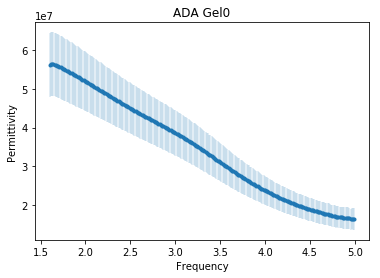

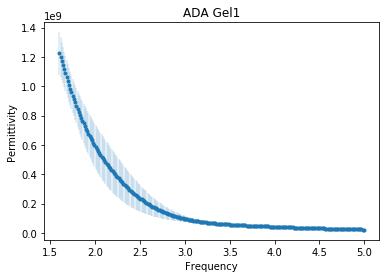

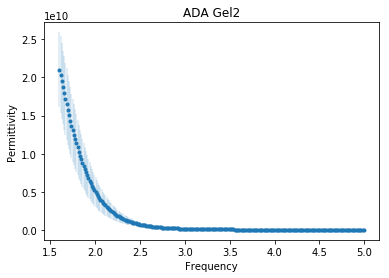

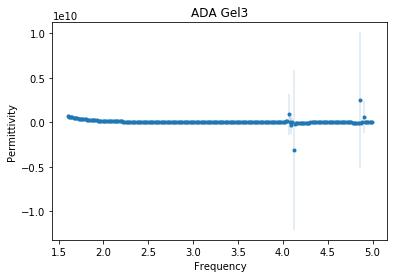

In [29]:
for i in snum:
    plt.errorbar(np.log10(Epsilon['Frequency']),Epsilon[i+'mean'],yerr=Epsilon[i+'std'],fmt='.',linewidth=0.25)
    plt.title('ADA Gel'+i)
    plt.xlabel('Frequency')
    plt.ylabel('Permittivity')
    plt.show()

In [30]:
Delta = Delta[Delta['Frequency']<=1e5]
Delta

,0mean,0std,1mean,1std,2mean,2std,3mean,3std,Frequency
0,0.554335,0.068985,0.638325,0.086176,0.801190,0.122452,0.342007,0.064687,40.000000
1,0.565091,0.067843,0.640966,0.087066,0.800950,0.122403,0.343302,0.064568,41.258999
2,0.574350,0.066701,0.643504,0.088061,0.800779,0.122336,0.344516,0.064432,42.557999
3,0.583041,0.065753,0.645889,0.088923,0.800540,0.122247,0.345910,0.064255,43.897999
4,0.591972,0.064923,0.648148,0.089905,0.800452,0.122197,0.347435,0.064197,45.279999
5,0.600699,0.064002,0.650552,0.090592,0.800415,0.122176,0.349046,0.064195,46.705002
6,0.609197,0.063183,0.652746,0.091525,0.800250,0.122110,0.350615,0.064044,48.175999
7,0.617820,0.062403,0.655001,0.092343,0.800232,0.122151,0.352412,0.064030,49.692001
8,0.626418,0.061603,0.657244,0.093065,0.800140,0.122087,0.354074,0.063855,51.257000
9,0.634996,0.060844,0.659465,0.093858,0.799988,0.121999,0.356089,0.063796,52.869999


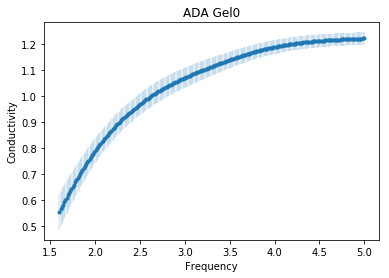

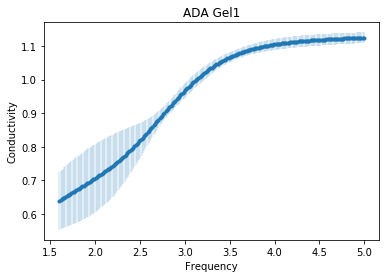

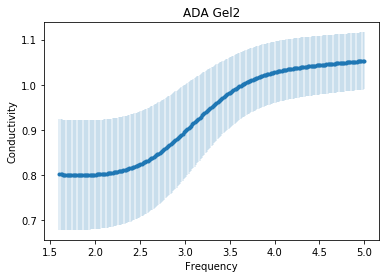

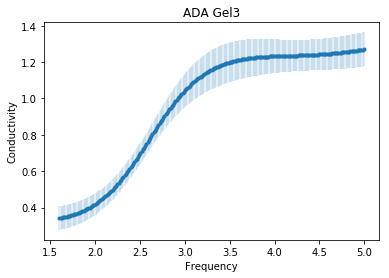

In [31]:
for i in snum:
    plt.errorbar(np.log10(Delta['Frequency']),Delta[i+'mean'],yerr=Delta[i+'std'],fmt='.',linewidth=0.25)
    plt.title('ADA Gel'+i)
    plt.xlabel('Frequency')
    plt.ylabel('Conductivity')
    plt.show()

# Output as an Excel file

In [32]:
op0 = fp10+fp11+'_Epsilon.xlsx'
op1 = fp10+fp11+'_Delta.xlsx'
fp3 = os.path.join(fp0,fp1,op0)
fp4 = os.path.join(fp0,fp1,op1)
Ep.to_excel(fp3,index=False)
Con.to_excel(fp4,index=False)


## Output
too slow

In [50]:
Z = readexcel(fp2, thickness)

1min 12s ± 1.41 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Old codes
discarded

14 
 ['b20', 'b21', 'b10', 'b11', 'b00', 'b01', 'b30', 'b31', 'b40', 'b41', 'b50', 'b51', 'b61', 'b60', 'b70', 'b71', 'b80', 'b81', 'b90', 'b91']
End


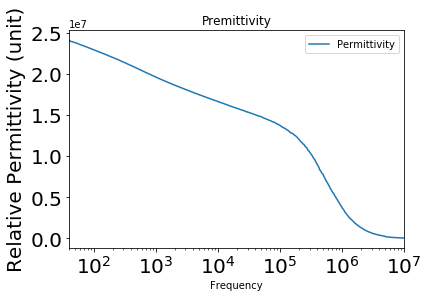

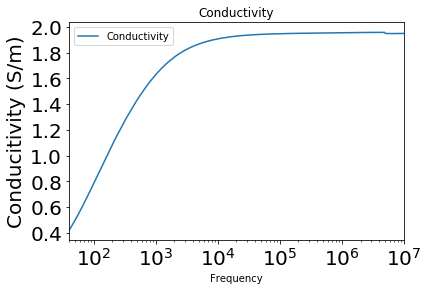

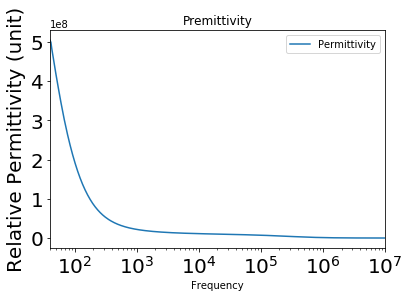

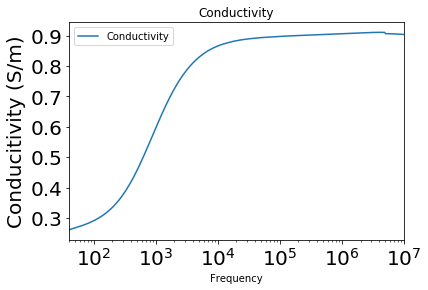

In [56]:
#_*_coding:utf-8_*_
# author: Fukun Shi, 2019-05-20
'''
计算ADA Gel的介电谱和导电率的平均值
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.constants as c

%matplotlib inline

m = 402

filepath = 'D:\\Nutstore\\PhD\\Experiment\\Cooperation-Biosensor\\ADA gel'
sub0 = '\\ADA-GEL'
sub1 = '\\0.1M_PPy'
data0 = '\\2019-05-17'
filename = '\\4294A_DataTransfer_0310.xlsx'

file_ada = filepath + sub0 + data0 + filename
file_01M = filepath + sub1 + data0 + filename

z0 = pd.ExcelFile(file_ada)
z1 = pd.ExcelFile(file_01M)
sheet0 = z0.sheet_names[2:]
nsheet0 = np.size(sheet0)
sheet1 = z1.sheet_names[2:]
nsheet1 = np.size(sheet1)
print(np.size(sheet0),'\n',sheet1)

fl = 40              # 频率范围下限
fh = 1e7
d = 0.5e-2             # 电极直径 m
A = np.pi*(d/2)**2   # 电极面积
t1 = np.array([2e-3]*nsheet1)
t0 = np.array([2e-3]*(nsheet0-3))     # ADA GEL有些样品厚度不一样
t0_ = np.array([1.6e-3,1.7e-3,1.6e-3]) 
t0 = np.hstack([t0,t0_])

def ED_mean(filepath,t,n):
    ED = pd.DataFrame()
    EDe = pd.DataFrame()
    EDc = pd.DataFrame()
    for i in range(n):
        EIS = pd.read_excel(filepath,sheet_name=[i+2],header=[9], skiprows=0, skipfooter=801-m+1, usecols=[2,3,5])
        EIS = EIS[i+2].values   # 将数据转为ndarray,方便转为pandas的dataframe形式
        # pd.read_excel直接读取，如果sheet_name不是默认值，结果都不是dataframe格式，需要转换为dataframe
        EIS = pd.DataFrame(EIS, columns=['Frequency','Real_Data', 'Image_Data'])
        data = EIS[(EIS.Frequency>=fl)&(EIS.Frequency<=fh)]
    
        freq = data['Frequency']
        Zre  = data['Real_Data']
        Zim  = data['Image_Data']
    
        w = 2*np.pi*freq
        C = -1/(w*Zim)
        c.epsilon_0                               # 具体常数信息可以用c.physical_constants['name']读取
    
        epsilon = t[i]*C/(A*c.epsilon_0)  # 相对介电常数
        delta = t[i]/(Zre*A)              # 电导率
        epsilon_im = delta/(w*c.epsilon_0)        # 相对损耗因子
    
        ede = pd.DataFrame({'Dielectric Constant'+str(i) : epsilon})
        edc = pd.DataFrame({'Conductivity'+str(i) : delta})
        EDe = pd.concat([EDe,ede],axis=1)
        EDc = pd.concat([EDc,edc],axis=1)
        ED['Freuquency'] = freq
        ED = pd.concat([ED,ede,edc],axis=1)

    ED_mean = pd.DataFrame(freq, columns=['Frequency'])
    ED_mean['Permittivity'] = EDe.mean(axis=1)
    ED_mean['Conductivity'] = EDc.mean(axis=1)
    
    ED_mean.plot('Frequency','Permittivity',logx=True, title='Premittivity',fontsize=20)
    plt.ylabel('Relative Permittivity (unit)',fontsize=20)
    ED_mean.plot('Frequency','Conductivity',logx=True, title='Conductivity',fontsize=20)
    plt.ylabel('Conducitivity (S/m)',fontsize=20)
    return ED_mean

ADA = ED_mean(file_ada,t0,nsheet0)
ADA01M = ED_mean(file_01M,t1,nsheet1)

print('End')

In [57]:
filepath0 = filepath + sub0 + '_mean.xlsx'
#ADA.to_excel(filepath0,index=False)
filepath1 = filepath + sub1 + '_mean.xlsx'
#ADA01M.to_excel(filepath1,index=False)

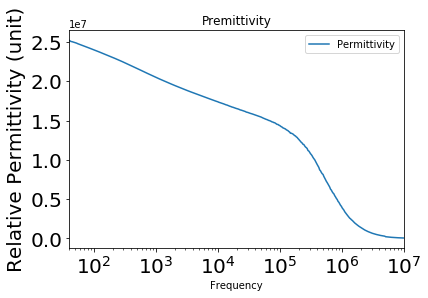

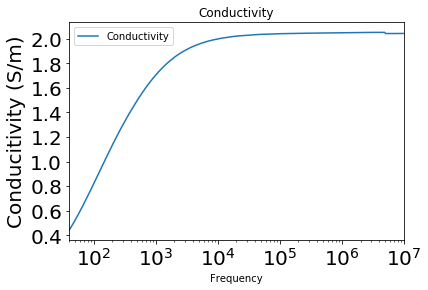

In [45]:
ED = pd.DataFrame()
EDe = pd.DataFrame()
EDc = pd.DataFrame()

for i in range(nsheet0):
    EIS = pd.read_excel(file_ada,sheet_name=[i+2],header=[9], skiprows=0, skipfooter=801-m+1, usecols=[2,3,5])
    EIS = EIS[i+2].values   # 将数据转为ndarray,方便转为pandas的dataframe形式
    # pd.read_excel直接读取，如果sheet_name不是默认值，结果都不是dataframe格式，需要转换为dataframe
    EIS = pd.DataFrame(EIS, columns=['Frequency','Real_Data', 'Image_Data'])
    data = EIS[(EIS.Frequency>=fl)&(EIS.Frequency<=fh)]
    
    freq = data['Frequency']
    Zre  = data['Real_Data']
    Zim  = data['Image_Data']
    
    w = 2*np.pi*freq
    C = -1/(w*Zim)
    c.epsilon_0                               # 具体常数信息可以用c.physical_constants['name']读取
    
    epsilon = t[i]*C/(A*c.epsilon_0)  # 相对介电常数
    delta = t[i]/(Zre*A)              # 电导率
    epsilon_im = delta/(w*c.epsilon_0)        # 相对损耗因子
    
    ede = pd.DataFrame({'Dielectric Constant'+str(i) : epsilon})
    edc = pd.DataFrame({'Conductivity'+str(i) : delta})
    EDe = pd.concat([EDe,ede],axis=1)
    EDc = pd.concat([EDc,edc],axis=1)
    ED['Freuquency'] = freq
    ED = pd.concat([ED,ede,edc],axis=1)

    
ED_mean = pd.DataFrame(freq, columns=['Frequency'])
ED_mean['Permittivity'] = EDe.mean(axis=1)
ED_mean['Conductivity'] = EDc.mean(axis=1)


ED_mean.plot('Frequency','Permittivity',logx=True, title='Premittivity',fontsize=20)
plt.ylabel('Relative Permittivity (unit)',fontsize=20)
ED_mean.plot('Frequency','Conductivity',logx=True, title='Conductivity',fontsize=20)
plt.ylabel('Conducitivity (S/m)',fontsize=20)
filepath0 = filepath + sub0 + '_mean.xlsx'
#ED_mean.to_excel(filepath0,index=False)